In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np
%matplotlib inline

In [2]:
data = pd.read_csv('Coal Futures Historical Data_univariate.csv', parse_dates=["Date"], index_col="Date")
data.head()

,Price,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6
Date,,,,,,
2018-12-14,76.05,NaN,NaN,NaN,NaN,NaN
2018-12-13,76.35,NaN,NaN,NaN,NaN,NaN
2018-12-12,76.35,NaN,NaN,NaN,NaN,NaN
2018-12-11,75.35,NaN,NaN,NaN,NaN,NaN
2018-12-10,74.65,NaN,NaN,NaN,NaN,NaN


In [158]:
new_data = data.dropna(axis='columns')

In [4]:
new_data.tail()

,Price
Date,
2015-11-23,40.80
2015-11-20,40.80
2015-11-19,41.05
2015-11-18,41.05
2015-11-17,41.05


In [208]:
test = new_data[:int(0.3*(len(data)))] #small
train = new_data[int(0.3*(len(data))):] #big
train.shape
test.head()

,Price
Date,
2018-12-14,76.05
2018-12-13,76.35
2018-12-12,76.35
2018-12-11,75.35
2018-12-10,74.65


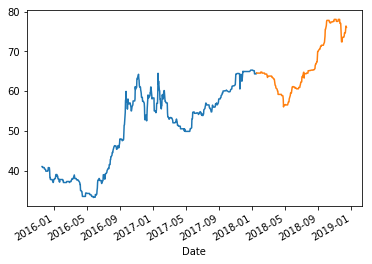

In [209]:
train['Price'].plot()
test['Price'].plot()

In [210]:
test1 = train.resample("Q").mean()
test1.tail()

,Price
Date,
2017-03-31,55.630469
2017-06-30,52.165397
2017-09-30,57.260156
2017-12-31,63.370492
2018-03-31,64.754545


In [211]:
#Test for stationarity
#Dicky-Fuller test

from pandas import Series
from statsmodels.tsa.stattools import adfuller
series = Series.from_csv('Coal Futures Historical Data_univariate.csv', parse_dates=["Date"], index_col="Date", header=0)
X = series.values
result = adfuller(X, autolag='AIC')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('Critical Value %s: %.3f' % (key, value))

ADF Statistic: -1.565283
p-value: 0.501006
Critical Values:
Critical Value 1%: -3.439
Critical Value 5%: -2.865
Critical Value 10%: -2.569


C:\Users\osman\Anaconda3\lib\site-packages\pandas\core\series.py:2890: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  infer_datetime_format=infer_datetime_format)


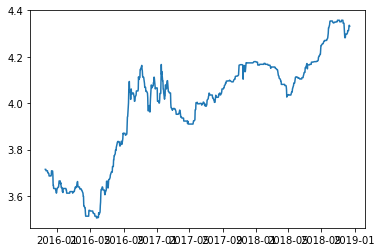

In [212]:
#estimating trend
data_logscale = np.log(new_data)
plt.plot(data_logscale)

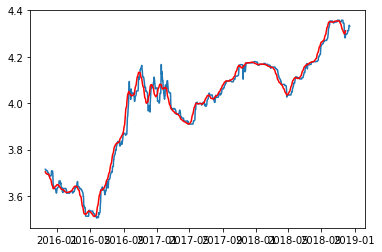

In [213]:
movingAverage = data_logscale.rolling(window=12).mean()
movingstd = data_logscale.rolling(window=12).std()
plt.plot(data_logscale)
plt.plot(movingAverage, color='red')

#trend not stationary

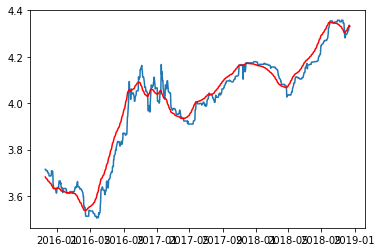

In [214]:
exponentialDecayWeightedAverage = data_logscale.ewm(halflife=12, min_periods=0, adjust=True).mean()
plt.plot(data_logscale)
plt.plot(exponentialDecayWeightedAverage, color='red')

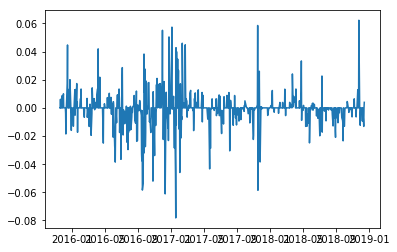

In [215]:
data_logscalediffshift = data_logscale - data_logscale.shift()
data_logscalediffshift.dropna(axis='columns')
plt.plot(data_logscalediffshift)

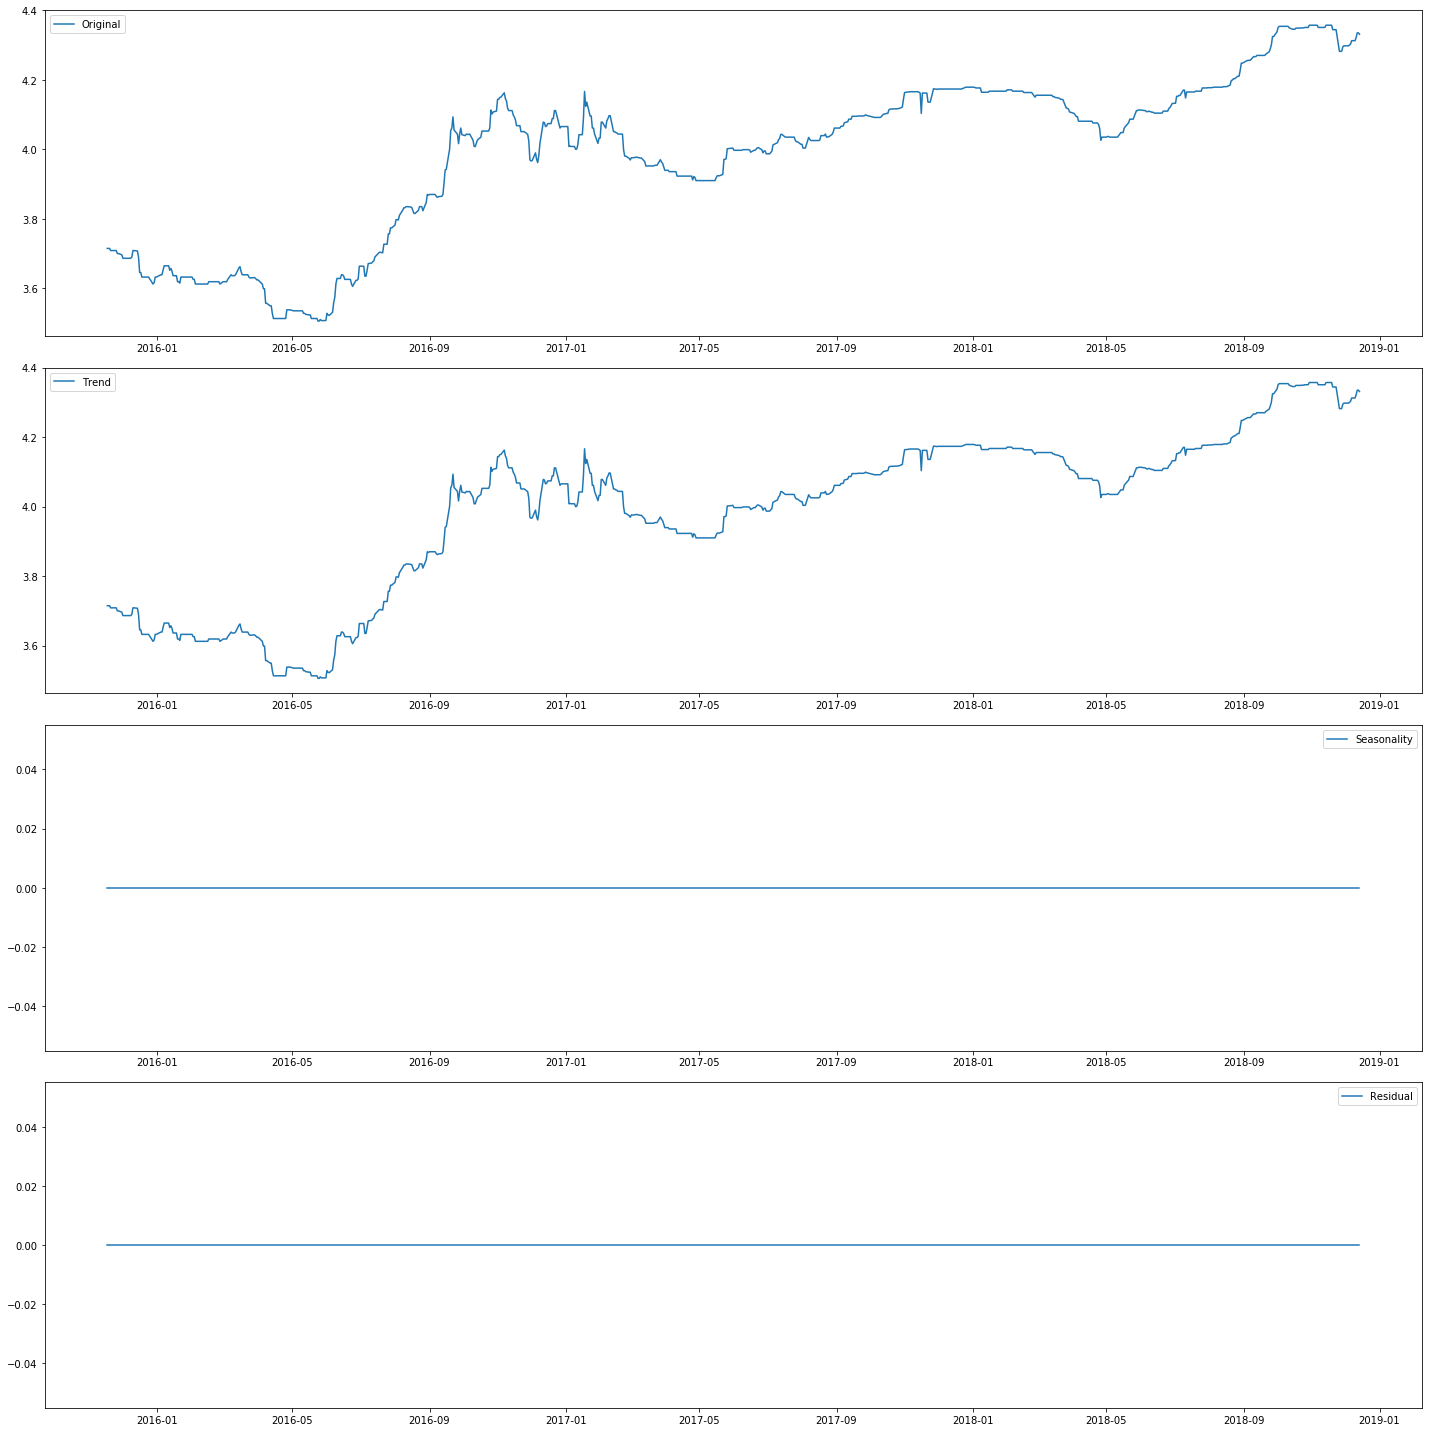

In [216]:
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib.pyplot import figure
decomposition = seasonal_decompose(data_logscale, model='additive', freq=1)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(20,20))

plt.subplot(411)
plt.plot(data_logscale, label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label='Residual')
plt.legend(loc='best')

plt.tight_layout()

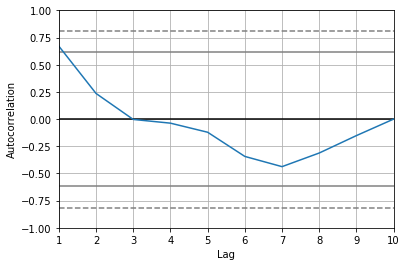

In [217]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(test1)
plt.show()

#p value for ARIMA roughly 0 or 1

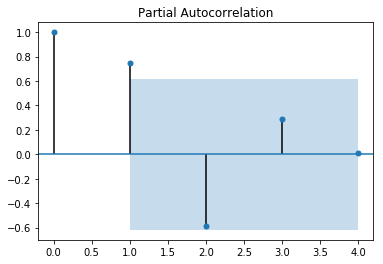

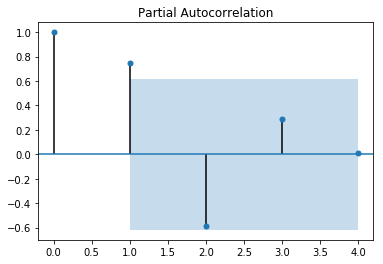

In [218]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(test1, lags=4)

Fit ARIMA: order=(2, 1, 2) seasonal_order=(1, 0, 1, 12); AIC=1219.679, BIC=1254.187, Fit time=1.651 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 12); AIC=1221.338, BIC=1229.965, Fit time=0.158 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 0, 0, 12); AIC=1222.074, BIC=1239.328, Fit time=0.309 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 1, 12); AIC=1222.654, BIC=1239.909, Fit time=0.262 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 0, 1, 12); AIC=1217.855, BIC=1248.050, Fit time=0.932 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 0, 0, 12); AIC=1215.985, BIC=1241.866, Fit time=0.469 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(0, 0, 0, 12); AIC=1216.396, BIC=1237.964, Fit time=0.267 seconds
Fit ARIMA: order=(3, 1, 2) seasonal_order=(0, 0, 0, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 0, 0, 12); AIC=1217.199, BIC=1238.767, Fit time=0.416 seconds
Fit ARIMA: order=(2, 1, 3) seasonal_orde

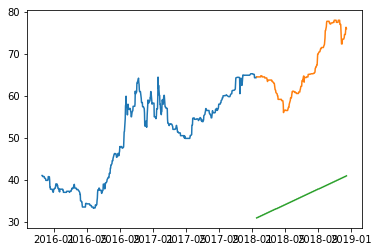

In [226]:
#building the model
#p-value > 0.05: Fail to reject the null hypothesis (H0), data has a unit root and is non-stationary.
#q-value is 3 since 3 are beyond critical boundaries
from pmdarima.arima import auto_arima

model = auto_arima(train, p=2, q=2, d=1, m=12, D=0, trace=True,
                   error_action='ignore',suppress_warnings=True, stationary=False)

#fit model to training data
model_fit = model.fit(train)
model.fit(train)
print(model.fit(train).summary())

#make predictions on test data
forecast = model.predict(n_periods=len(test))
forecast = pd.DataFrame(forecast,index = test.index,columns=['Prediction'])

#plot the predictions for validation set
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(forecast, label='Prediction')
plt.show()

In [220]:
import statsmodels.api as sm

mod = sm.tsa.statespace.SARIMAX(train, trend='n', order=(2,1,4), seasonal_order=(1,0,0,12))
results = mod.fit()
print(results.summary())

C:\Users\osman\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                                 Statespace Model Results                                 
Dep. Variable:                              Price   No. Observations:                  553
Model:             SARIMAX(2, 1, 4)x(1, 0, 0, 12)   Log Likelihood                -594.537
Date:                            Thu, 27 Dec 2018   AIC                           1205.075
Time:                                    16:16:02   BIC                           1239.583
Sample:                                         0   HQIC                          1218.558
                                            - 553                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1165      0.048     23.034      0.000       1.021       1.211
ar.L2         -0.8299      0.041   

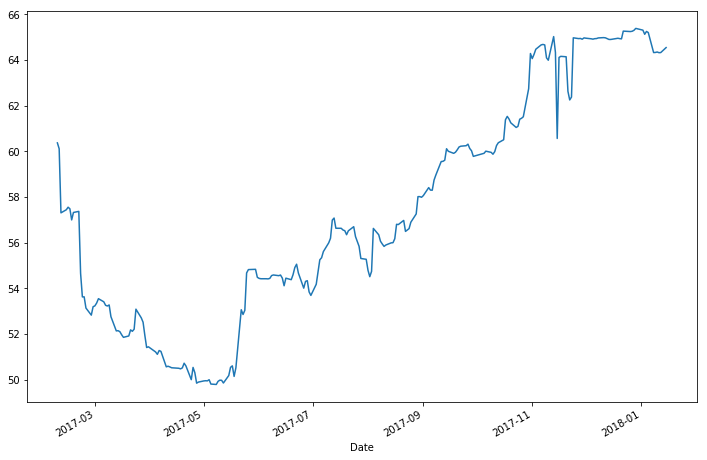

In [221]:
data['forecast'] = results.predict(start=1, end=len(test), dynamic= False)
#plt.plot(test, label='Test')
#plt.plot(train, label='Test')
data[ 'forecast'].plot(figsize=(12, 8))

In [222]:
#calculate rmse
#lower rmse = better fit
from math import sqrt
from sklearn.metrics import mean_squared_error

rms = sqrt(mean_squared_error(test,forecast))
print(rms)

30.936899539235306


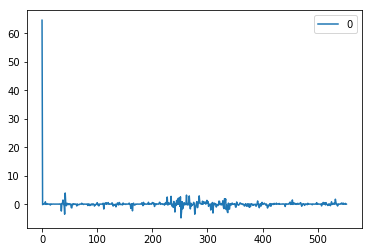

In [223]:
from pandas import DataFrame
residuals = DataFrame(model_fit.resid())
residuals.plot()

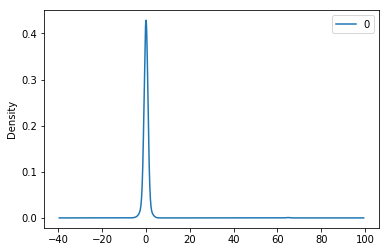

In [224]:
residuals.plot(kind='kde')

In [225]:
residuals.describe()

,0
count,553.000000
mean,0.116881
std,2.839570
min,-4.818243
25%,-0.085523
50%,0.036678
75%,0.143314
max,64.592695
